In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow==2.14

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/freiburg_groceries_dataset/images')

In [ ]:
list(data_dir.iterdir())

[PosixPath('/content/drive/MyDrive/freiburg_groceries_dataset/images/CEREAL'),
 PosixPath('/content/drive/MyDrive/freiburg_groceries_dataset/images/CANDY'),
 PosixPath('/content/drive/MyDrive/freiburg_groceries_dataset/images/TEA'),
 PosixPath('/content/drive/MyDrive/freiburg_groceries_dataset/images/JUICE'),
 PosixPath('/content/drive/MyDrive/freiburg_groceries_dataset/images/COFFEE'),
 PosixPath('/content/drive/MyDrive/freiburg_groceries_dataset/images/WATER'),
 PosixPath('/content/drive/MyDrive/freiburg_groceries_dataset/images/NUTS'),
 PosixPath('/content/drive/MyDrive/freiburg_groceries_dataset/images/JAM'),
 PosixPath('/content/drive/MyDrive/freiburg_groceries_dataset/images/TOMATO_SAUCE'),
 PosixPath('/content/drive/MyDrive/freiburg_groceries_dataset/images/CAKE'),
 PosixPath('/content/drive/MyDrive/freiburg_groceries_dataset/images/VINEGAR'),
 PosixPath('/content/drive/MyDrive/freiburg_groceries_dataset/images/RICE'),
 PosixPath('/content/drive/MyDrive/freiburg_groceries_datase

/content/drive/MyDrive/freiburg_groceries_dataset/images/CAKE/CAKE0018_Flip_UP.png


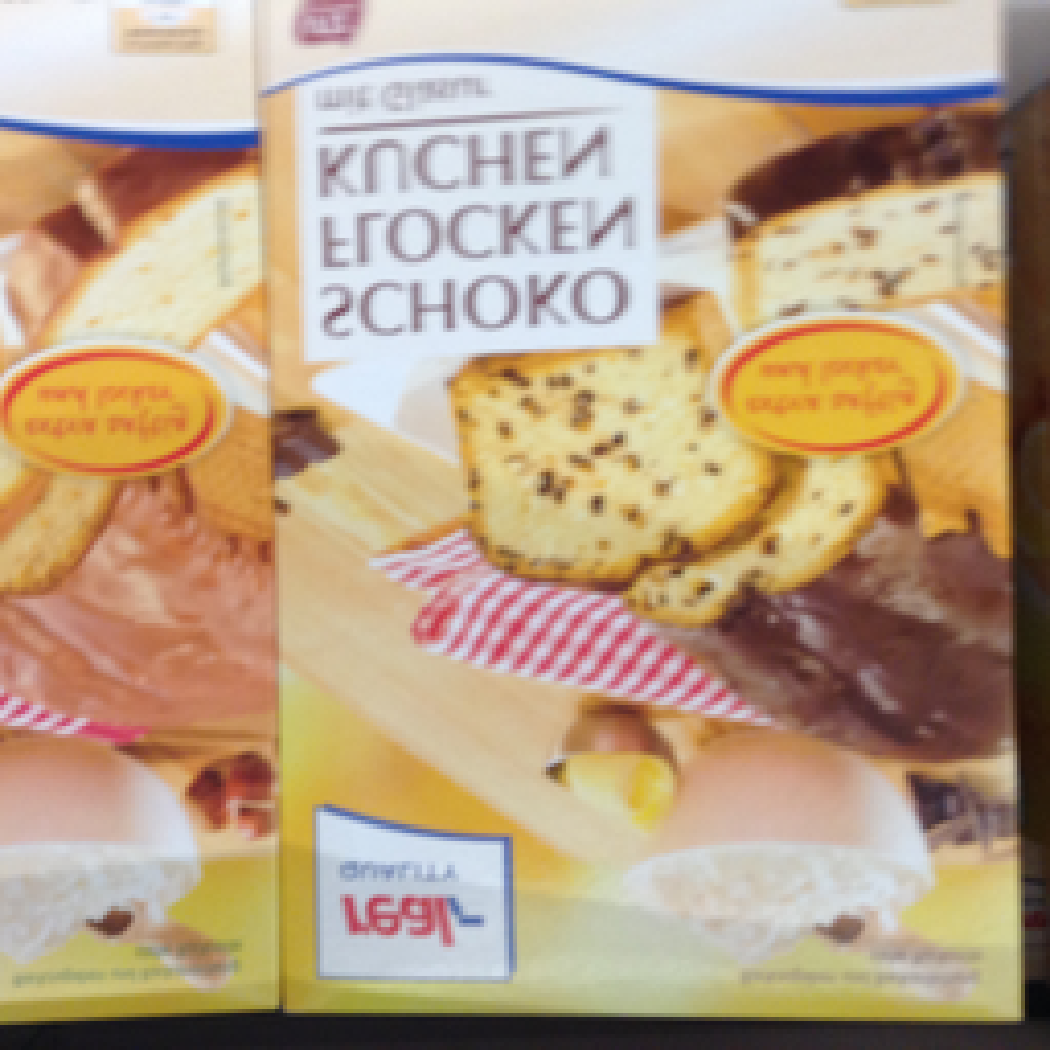

In [ ]:
import matplotlib.pyplot as plt
import PIL
dairy = list(data_dir.glob('CAKE/*'))
print(dairy[0])
PIL.Image.open(str(dairy[0]))

In [ ]:
img_height,img_width=32,32
batch_size=64
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6074 files belonging to 25 classes.
Using 5467 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6074 files belonging to 25 classes.
Using 607 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['BEANS', 'CAKE', 'CANDY', 'CEREAL', 'CHIPS', 'CHOCOLATE', 'COFFEE', 'CORN', 'FISH', 'FLOUR', 'HONEY', 'JAM', 'JUICE', 'MILK', 'NUTS', 'OIL', 'PASTA', 'RICE', 'SODA', 'SPICES', 'SUGAR', 'TEA', 'TOMATO_SAUCE', 'VINEGAR', 'WATER']


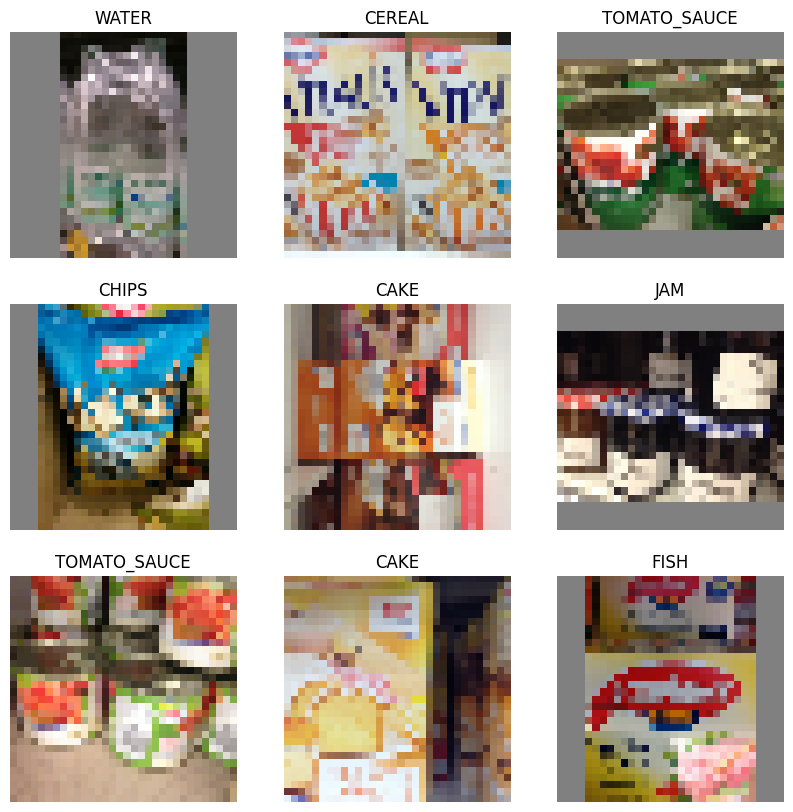

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
#with dropout
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(256,activation=('relu')))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(512,activation=('relu')))
resnet_model.add(Dense(128,activation=('relu')))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(10,activation=('softmax')))

In [ ]:
!pip install tensorflow-addons==0.23.0

  Using cached tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (611 kB)
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.18.0
    Uninstalling tensorflow-addons-0.18.0:
      Successfully uninstalled tensorflow-addons-0.18.0


In [ ]:
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.14.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're us

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
import tensorflow_addons as tfa

# Define the custom metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Compile the model
resnet_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', f1_m, precision_m, recall_m]
)


In [ ]:
# Modify the output layer to match the number of classes
# Assuming `resnet_model` is a Sequential model, replace the final layer:
resnet_model.add(Dense(25, activation='softmax'))  # for 25 classes

# Then recompile
resnet_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', f1_m, precision_m, recall_m]
)


In [ ]:
epochs=20
try:
    history = resnet_model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
    )
except:
    print("Invalid Image")

86/86 [==============================] - 967s 11s/step - loss: 3.0140 - accuracy: 0.2136 - f1_m: 15.7434 - precision_m: 4897326592.0000 - recall_m: 7.8717 - val_loss: 2.9964 - val_accuracy: 0.1960 - val_f1_m: 13.4024 - val_precision_m: 4026000128.0000 - val_recall_m: 6.7012


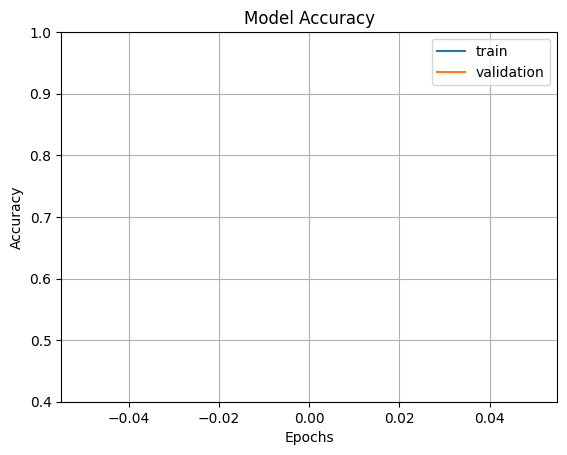

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

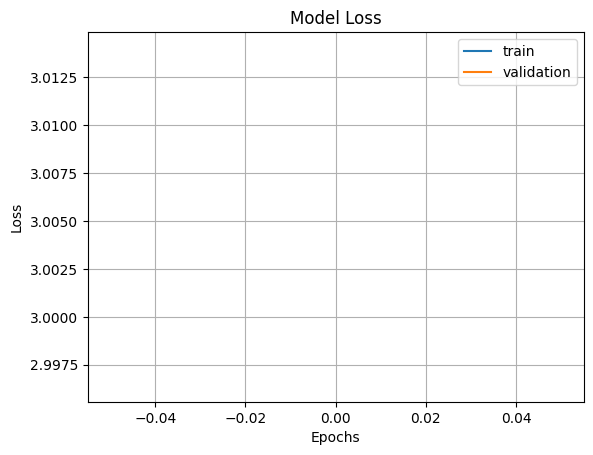

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
resnet_model.save('model')

In [ ]:
import cv2
image=cv2.imread('test_image4.jpeg')
image_resized = cv2.resize(image,(img_height,img_width))
image=np.expand_dims(image_resized,axis=0)

In [ ]:
pred=resnet_model.predict(image)
print(pred)

In [ ]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)